In this notebook, you should implement a first version of a working machine learning model to predict the age of an Abalone.

A few guidelines:
- The model does not have to be complex. A simple linear regression model is enough.
- You should use MLflow to track your experiments. You can use the MLflow UI to compare your experiments.
- Do not push any MLflow data to the repository. Only the code to run the experiments is interesting and should be pushed.

In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import mlflow
import mlflow.sklearn
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

pd.set_option("display.max_columns", 500)
sns.set_style("whitegrid")

/Users/jamaimamoun/Desktop/HEC/ML_ops_Artefact/xhec-mlops-2025/.venv/lib/python3.11/site-packages/mlflow/utils/requirements_utils.py:20: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources  # noqa: TID251


In [2]:
df = pd.read_csv("abalone.csv")

# FE 

In [3]:
df["Age"] = df["Rings"] + 1.5

In [4]:
df = df[df["Height"] > 0]

One Hot Encoding of sex features 

In [5]:
df = pd.get_dummies(df, columns=["Sex"], drop_first=False)

In [6]:
# Ensure no division by zero (should be handled by step 1, but good practice)
df = df[df["Whole weight"] > 0]

# Density (approximated)
df["density"] = df["Whole weight"] / (df["Length"] * df["Diameter"] * df["Height"])

# Ratio of meat to total weight
df["meat_ratio"] = df["Shucked weight"] / df["Whole weight"]

# Ratio of shell to total weight (highly correlated with Rings)
df["shell_ratio"] = df["Shell weight"] / df["Whole weight"]

# Water loss (weight of un-shuckable parts)
df["water_loss"] = df["Whole weight"] - df["Shucked weight"] - df["Viscera weight"] - df["Shell weight"]

In [7]:
df = df.drop(columns=["Length", "Diameter", "Whole weight", "Shucked weight", "Viscera weight", "Shell weight"])

In [8]:
# Use log1p to safely handle any potential 0s (though min is 1 here)
df["Age_log"] = np.log1p(df["Age"])

# Apply log transform to other features
df["Height_log"] = np.log1p(df["Height"])
df["density_log"] = np.log1p(df["density"])
df["meat_ratio_log"] = np.log1p(df["meat_ratio"])
df["shell_ratio_log"] = np.log1p(df["shell_ratio"])

In [9]:
df = df.drop(columns=["Rings", "Height", "density", "meat_ratio", "shell_ratio"])

In [10]:
from sklearn.preprocessing import StandardScaler

# Select only the columns you created
features_to_scale = ["water_loss"]

scaler = StandardScaler()
df[features_to_scale] = scaler.fit_transform(df[features_to_scale])

In [11]:
# Séparer features et target
X = df.drop(columns=["Age_log"])
y = df["Age_log"]

# Split train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Train size: {X_train.shape}")
print(f"Test size: {X_test.shape}")

Train size: (3340, 9)
Test size: (835, 9)


In [12]:
# Démarrer MLflow run
mlflow.set_experiment("abalone_age_prediction")

with mlflow.start_run():
    # Entraîner le modèle
    model = LinearRegression()
    model.fit(X_train, y_train)

    # Prédictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Métriques
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Log métriques
    mlflow.log_metric("train_rmse", train_rmse)
    mlflow.log_metric("test_rmse", test_rmse)
    mlflow.log_metric("train_mae", train_mae)
    mlflow.log_metric("test_mae", test_mae)
    mlflow.log_metric("test_r2", test_r2)

    # Log modèle
    mlflow.sklearn.log_model(model, "model")

    # Afficher résultats
    print(f"Train RMSE: {train_rmse:.4f}")
    print(f"Test RMSE: {test_rmse:.4f}")
    print(f"Test MAE: {test_mae:.4f}")
    print(f"Test R2: {test_r2:.4f}")

2025/10/23 12:37:27 INFO mlflow.tracking.fluent: Experiment with name 'abalone_age_prediction' does not exist. Creating a new experiment.


Train RMSE: 0.0433
Test RMSE: 0.0439
Test MAE: 0.0283
Test R2: 0.9709


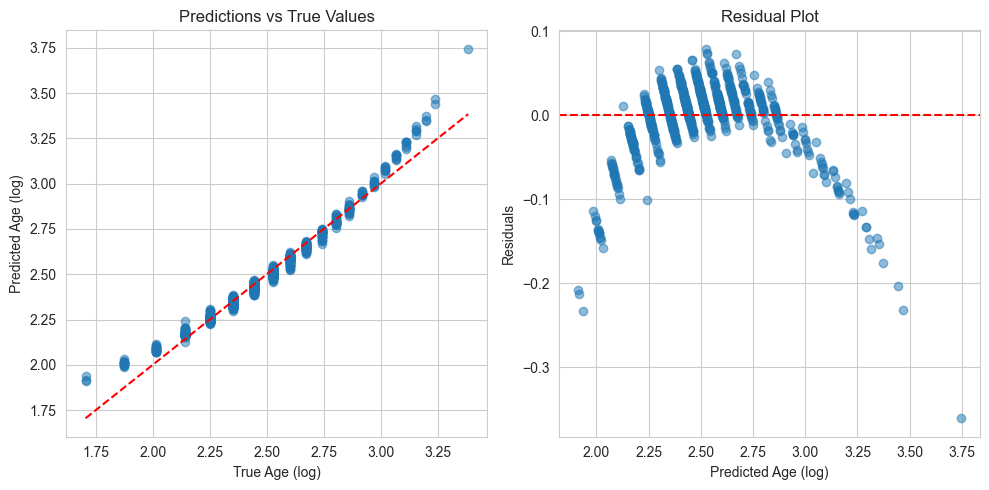

In [13]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.scatter(y_test, y_test_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("True Age (log)")
plt.ylabel("Predicted Age (log)")
plt.title("Predictions vs True Values")

plt.subplot(1, 2, 2)
residuals = y_test - y_test_pred
plt.scatter(y_test_pred, residuals, alpha=0.5)
plt.axhline(y=0, color="r", linestyle="--")
plt.xlabel("Predicted Age (log)")
plt.ylabel("Residuals")
plt.title("Residual Plot")

plt.tight_layout()
plt.show()

In [14]:
# Random Forest avec régularisation
rf_model_simple = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1, max_depth=10, min_samples_leaf=5)

print("Entraînement du Random Forest...")
rf_model_simple.fit(X_train, y_train)
print("Entraînement terminé.")

# Prédictions
y_pred_train = rf_model_simple.predict(X_train)
y_pred_test = rf_model_simple.predict(X_test)

# Métriques sur données log-transformées
train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
test_mae = mean_absolute_error(y_test, y_pred_test)
test_r2 = r2_score(y_test, y_pred_test)

print(f"\nTrain RMSE (log): {train_rmse:.4f}")
print(f"Test RMSE (log): {test_rmse:.4f}")
print(f"Test MAE (log): {test_mae:.4f}")
print(f"Test R2 (log): {test_r2:.4f}")

# Métriques en nombre d'anneaux réels
y_test_orig = np.expm1(y_test)
y_pred_test_orig = np.expm1(y_pred_test)

test_rmse_orig = np.sqrt(mean_squared_error(y_test_orig, y_pred_test_orig))
test_mae_orig = mean_absolute_error(y_test_orig, y_pred_test_orig)

print(f"\nTest RMSE (anneaux): {test_rmse_orig:.4f}")
print(f"Test MAE (anneaux): {test_mae_orig:.4f}")

Entraînement du Random Forest...
Entraînement terminé.

Train RMSE (log): 0.0082
Test RMSE (log): 0.0046
Test MAE (log): 0.0004
Test R2 (log): 0.9997

Test RMSE (anneaux): 0.0930
Test MAE (anneaux): 0.0070
